In [3]:
%load_ext autoreload
%autoreload 2

# imports 
import os
import time
import pickle
import importlib
from collections import defaultdict
from pathlib import Path
import json

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pydicom
import nibabel as nib
import dicom2nifti
import dicom2nifti.settings as settings
settings.disable_validate_slice_increment()
import SimpleITK as sitk
from PIL import Image
from radiomics import featureextractor as extractor
from glob import glob

import numba
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr, pearsonr, ttest_ind

from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score, roc_curve, r2_score  # plot_roc_curve
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin


import re
from pathlib import Path
from collections import defaultdict

# # # custom imports:
# import cseg_utils
# import cseg_utils.utils
# import cseg_utils.project_specific.hvpg.dataset
# from cseg_utils.project_specific.hvpg.dataset.dataset import load_image_hvpg_data_and_split_info, get_files_dict_by_regex_pattern
# from typing import Literal 



import radipop_utils 
import radipop_utils.visualization
import radipop_utils.features
from radipop_utils.features import (
    convert_and_extract_from_nii,
)

# load user/ system specific env variables:
from dotenv import dotenv_values, find_dotenv
config = dotenv_values(find_dotenv())  # load environment variables as dictionary

# path to the data. You will (likely need to change this)
DATA_ROOT_DIRECTORY = Path(config["DATA_ROOT_DIRECTORY"])

import os
from pathlib import Path
import radipop_utils

# needed for loading the settings for the radiomics feature extractor 
path = Path(os.path.abspath(radipop_utils.__file__))
RADIPOP_PACKAGE_ROOT = path.parent.parent


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Notes:** DICOM to NII conversion
We will assume that this was already done. 
If not, you can use the function: `radipop_utils.utils.dcm2nii` as such:

```python
# convert one dicom folder: 
out_path = Path("/path/to/where/you/want/the/nii/files/")
path_input_single = Path("/path/to/dicom/folder")
radipop_utils.utils.dcm2nii(path_input_single, out_path, out_id = "patient12345")
```

We moreover assume that the segementation masks are available. In the case of the RADIPOP manuscript these were generated with a custom segmentation software used by the radiologists. This software is available upon request.

In [4]:


dataset = "Dataset125_LSS"
#df = load_image_hvpg_data_and_split_info(DATA_ROOT_DIRECTORY, dataset=dataset)
# df.to_excel(RADIPOP_PACKAGE_ROOT / "data" / "file_paths_and_hvpg_data.xlsx")


df = pd.read_excel(RADIPOP_PACKAGE_ROOT / "data" / "file_paths_and_hvpg_data.xlsx")

# df.head()

In [5]:

RADIOMICS_DIR = DATA_ROOT_DIRECTORY / "radiomics" / dataset / "radipop"
os.makedirs(RADIOMICS_DIR, exist_ok=True)


Let's visualize how our masks /cts look like. This is of course optional

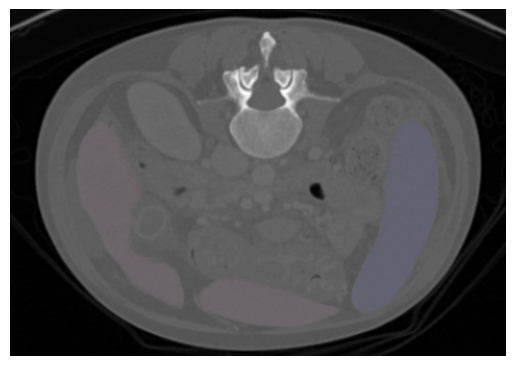

In [8]:
# # load image and plot overlayed masks + image for one slice:
# note that this has a bad contrast. It is better to use some windowing. 

image_loc = df.loc[0, "images"]
mask_loc = df.loc[0, "masks"]
patientid = df.loc[0, "id"]

mask = sitk.ReadImage(mask_loc)
img = sitk.ReadImage(image_loc)

img_array = sitk.GetArrayFromImage(img)
mask_array = sitk.GetArrayFromImage(mask)

idx = 120
image_xy_slice = img_array[idx, :, :]
label_xy_slice = mask_array[idx, :, :]

crop = lambda x: radipop_utils.visualization.crop_image(x, top_ratio=0.15, bottom_ratio=0.2, left_ratio=0.05, right_ratio=0.02)
image_xy_slice = crop(image_xy_slice)
label_xy_slice = crop(label_xy_slice)

color_dictionary = {
    'violet': (170/255, 48/255, 127/255, 0.25),
    'blue':   (0, 0, 1, 0.25),
}
#                                         ct               liver                        spleen                      
radipop_utils.visualization.overlay_masks(image_xy_slice, [label_xy_slice==1,           label_xy_slice==2], 
                                                          [color_dictionary['violet'],  color_dictionary['blue']]);

In [9]:
fe_setting = RADIPOP_PACKAGE_ROOT / "yaml" / "exampleCT.yaml"


(223, 512, 512)


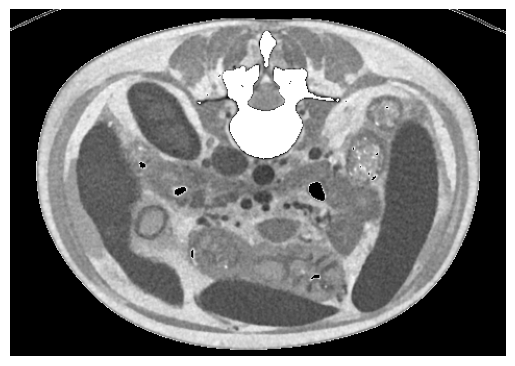

In [17]:
# Perform some windowing on the image: 
# a typical soft tissue window is  wl=50, ww=500
# in the paper wl=60, ww=400 was used.

img_transformed = convert_and_extract_from_nii(image_loc, out_range=[0, 255], wl=60, ww=400, dtype=np.uint8)  

img_array = sitk.GetArrayFromImage(img_transformed)
mask_array = sitk.GetArrayFromImage(mask)

idx = 120
image_xy_slice = img_array[idx, :, :]
label_xy_slice = mask_array[idx, :, :]

crop = lambda x: radipop_utils.visualization.crop_image(x, top_ratio=0.15, bottom_ratio=0.2, left_ratio=0.05, right_ratio=0.02)
image_xy_slice = crop(image_xy_slice)
label_xy_slice = crop(label_xy_slice)

color_dictionary = {
    'violet': (170/255, 48/255, 127/255, 0.35),
    'blue':   (0, 0, 1, 0.35),
}
#                                         ct               liver                        spleen                      
radipop_utils.visualization.overlay_masks(image_xy_slice, [], []);# , [label_xy_slice==1,           label_xy_slice==2], 
                                                          # [color_dictionary['violet'],  color_dictionary['blue']]);